# Setup

In [1]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 76.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:000:00:0100:01

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import multiprocessing
import time

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# from lightautoml.automl.presets.tabular_presets import TabularAutoML
# from lightautoml.validation.np_iterators import TimeSeriesIterator
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

# from xgboost import XGBRegressor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [3]:
N_THREADS = multiprocessing.cpu_count()
N_FOLDS = 5
TEST_SIZE = 0.2
TIMEOUT = 500
TARGET_NAME = 'Return'
RANDOM_STATE = 59
HORIZON = 10
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Data

In [4]:
ds_path = '/kaggle/input/stock-price-prediction-challenge'
os.listdir(ds_path)

['sample_submission.csv', 'test', 'train']

In [5]:
train_index_example = pd.read_csv('/kaggle/input/stock-price-prediction-challenge/train/indices/Dow_Jones.csv')
train_index_example.head()

,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2015-01-02,DJI,17823.070312,17951.779297,17731.300781,17832.990234,17832.990234,NaN,76270000
1,2015-01-05,DJI,17821.300781,17821.300781,17475.929688,17501.650391,17501.650391,-0.018580,116160000
2,2015-01-06,DJI,17504.179688,17581.050781,17262.369141,17371.640625,17371.640625,-0.007428,101870000
3,2015-01-07,DJI,17374.779297,17597.080078,17374.779297,17584.519531,17584.519531,0.012254,91030000
4,2015-01-08,DJI,17591.970703,17916.039062,17591.970703,17907.869141,17907.869141,0.018388,114890000


In [6]:
first_test = pd.read_csv('/kaggle/input/stock-price-prediction-challenge/test/test_1.csv')
first_test.head()

,Date,Open,High,Low,Close,Adjusted,Returns,Volume
0,2015-01-05,55.889999,57.520000,55.639999,56.990002,56.990002,0.014057,593600
1,2015-01-06,57.330002,57.939999,56.790001,57.450001,57.450001,0.008072,825000
2,2015-01-07,57.970001,59.750000,57.450001,59.570000,59.570000,0.036902,1053500
3,2015-01-08,60.000000,61.669998,59.740002,61.439999,61.439999,0.031392,1289100
4,2015-01-09,61.669998,62.820000,61.500000,62.580002,62.580002,0.018555,1549400


В папке 'train' хранятся исторические данные трех индексов и самых различных акций, которые можно использовать для поиска общих закономерностей, статистик, фичей. Особенно полезны должны быть индексы, так как в них по определению отражена динамика большого кол-ва акций.


В папке 'test' у нас 5 разных безымянных акций. Для каждой из них нужно сделать предикт на 10 дней вперед. Csv содержат все их признаки до первого для предсказаний не включительно.


В качестве таргета у нас колонка Returns - это процентная доля изменения между 'Close' текущего дня и предыдущего, т.е. 'Close_today'/'Close_yesterday' - 1.0


Самый минимальный вариант - не использовать исторические данные из 'train' и даже колонки из 'test_i.csv' кроме 'Returns', просто зафитить под каждый временной ряд 'Returns_i' отдельную модель и сделать предикт на 10 дней, объединить предсказания моделей в сабмишен.


В качестве lightautoml модели буду использовать AutoTS пресет, по одной модели на каждую тестовую акцию. 


В качестве моделей-"соперников" зафичу нейронную сеть на основе LSTM, которая сможет нативно обучиться на дополнительных фичах из feature engineering. Каждая такая модель будет учиться на дневных отрезках (N)-(10), чтобы на текущих N днях предсказать следующие 10 дней. 

In [7]:
def read_test_dfs(test_path):  
    test_dfs = []
    
    for i in range(1, 6):
        df = pd.read_csv(os.path.join(test_path, f"test_{i}.csv"))
        df = df.rename(columns={
            "Low": f"low_{i}",
            "High": f"high_{i}",
            "Open": f"open_{i}",
            "Returns": f"return_{i}",
            "Close": f"close_{i}",
            "Volume": f"volume_{i}"
        })
        # redundant column
        df = df.drop(columns=['Adjusted'])
        test_dfs.append(df)

    merged_df = test_dfs[0][['Date', f'low_1', f'high_1', f'open_1', f'return_1', f'close_1', f'volume_1']]
    for i in range(1, 5):
        df_i = test_dfs[i][['Date', f'low_{i+1}', f'high_{i+1}', f'open_{i+1}', f'return_{i+1}', f'close_{i+1}', f'volume_{i+1}']]
        merged_df = pd.merge(merged_df, df_i, on='Date', how='outer')
    
    return merged_df


def read_test_i_dataframe(test_path, split_idx):
    df = pd.read_csv(os.path.join(test_path, f"test_{split_idx}.csv"))
    df = df.rename(columns={
            "Low": f"low_{split_idx}",
            "High": f"high_{split_idx}",
            "Open": f"open_{split_idx}",
            "Returns": f"return_{split_idx}",
            "Close": f"close_{split_idx}",
            "Volume": f"volume_{split_idx}"
    })
    # redundant column
    df = df.drop(columns=['Adjusted'])
    return df


def add_indices_dfs(df_to_add, indices_path, indices_names):
    indices = {
        "dj": "Dow_Jones.csv",
        "nasdaq": "NASDAQ.csv",
        "SP500": "SP500.csv"
    }

    df_to_add = df_to_add.copy()
    for name in indices_names:
        if name in indices.keys():
            index_df = pd.read_csv(os.path.join(indices_path, indices[name]))
            index_df = index_df.rename(columns={"Returns": f"return_{name}"})
            df_to_add = pd.merge(df_to_add, index_df[['Date', f'return_{name}']], on='Date', how='left')

    return df_to_add

In [8]:
test_path = "/kaggle/input/stock-price-prediction-challenge/test"
indices_path = "/kaggle/input/stock-price-prediction-challenge/train/indices"

merged_df = read_test_dfs(test_path)
# добавлю один из исторических индексов к данным
indices_names = ['SP500']
merged_df = add_indices_dfs(merged_df, indices_path, indices_names)

# data sort
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values('Date').reset_index(drop=True)

print(merged_df.head(), merged_df.shape)

        Date      low_1     high_1     open_1  return_1    close_1  volume_1  \
0 2015-01-05  55.639999  57.520000  55.889999  0.014057  56.990002    593600   
1 2015-01-06  56.790001  57.939999  57.330002  0.008072  57.450001    825000   
2 2015-01-07  57.450001  59.750000  57.970001  0.036902  59.570000   1053500   
3 2015-01-08  59.740002  61.669998  60.000000  0.031392  61.439999   1289100   
4 2015-01-09  61.500000  62.820000  61.669998  0.018555  62.580002   1549400   

        low_2      high_2      open_2  ...  return_4  close_4  volume_4  \
0  136.224396  138.965851  136.585373  ...       NaN      NaN       NaN   
1  135.853653  138.370728  138.048782  ...       NaN      NaN       NaN   
2  137.482925  140.458542  137.482925  ...       NaN      NaN       NaN   
3  141.160980  143.160980  141.443909  ...       NaN      NaN       NaN   
4  140.829269  142.292679  141.570724  ...       NaN      NaN       NaN   

       low_5     high_5     open_5  return_5    close_5  volume_5  \

In [9]:
col_nans_sum = {col: sum(merged_df[col].isna()) for col in merged_df.columns}
for k, v in col_nans_sum.items():
    print(f'{k} : {v} nans')

Date : 0 nans
low_1 : 0 nans
high_1 : 0 nans
open_1 : 0 nans
return_1 : 0 nans
close_1 : 0 nans
volume_1 : 0 nans
low_2 : 0 nans
high_2 : 0 nans
open_2 : 0 nans
return_2 : 0 nans
close_2 : 0 nans
volume_2 : 0 nans
low_3 : 0 nans
high_3 : 0 nans
open_3 : 0 nans
return_3 : 0 nans
close_3 : 0 nans
volume_3 : 0 nans
low_4 : 1468 nans
high_4 : 1468 nans
open_4 : 1468 nans
return_4 : 1468 nans
close_4 : 1468 nans
volume_4 : 1468 nans
low_5 : 0 nans
high_5 : 0 nans
open_5 : 0 nans
return_5 : 0 nans
close_5 : 0 nans
volume_5 : 0 nans
return_SP500 : 0 nans


У четвертого тестового набора много NaN по всем колонкам, но обучать буду по одной модели на каждую тестовую акцию, так что это не особо проблема.

# EDA

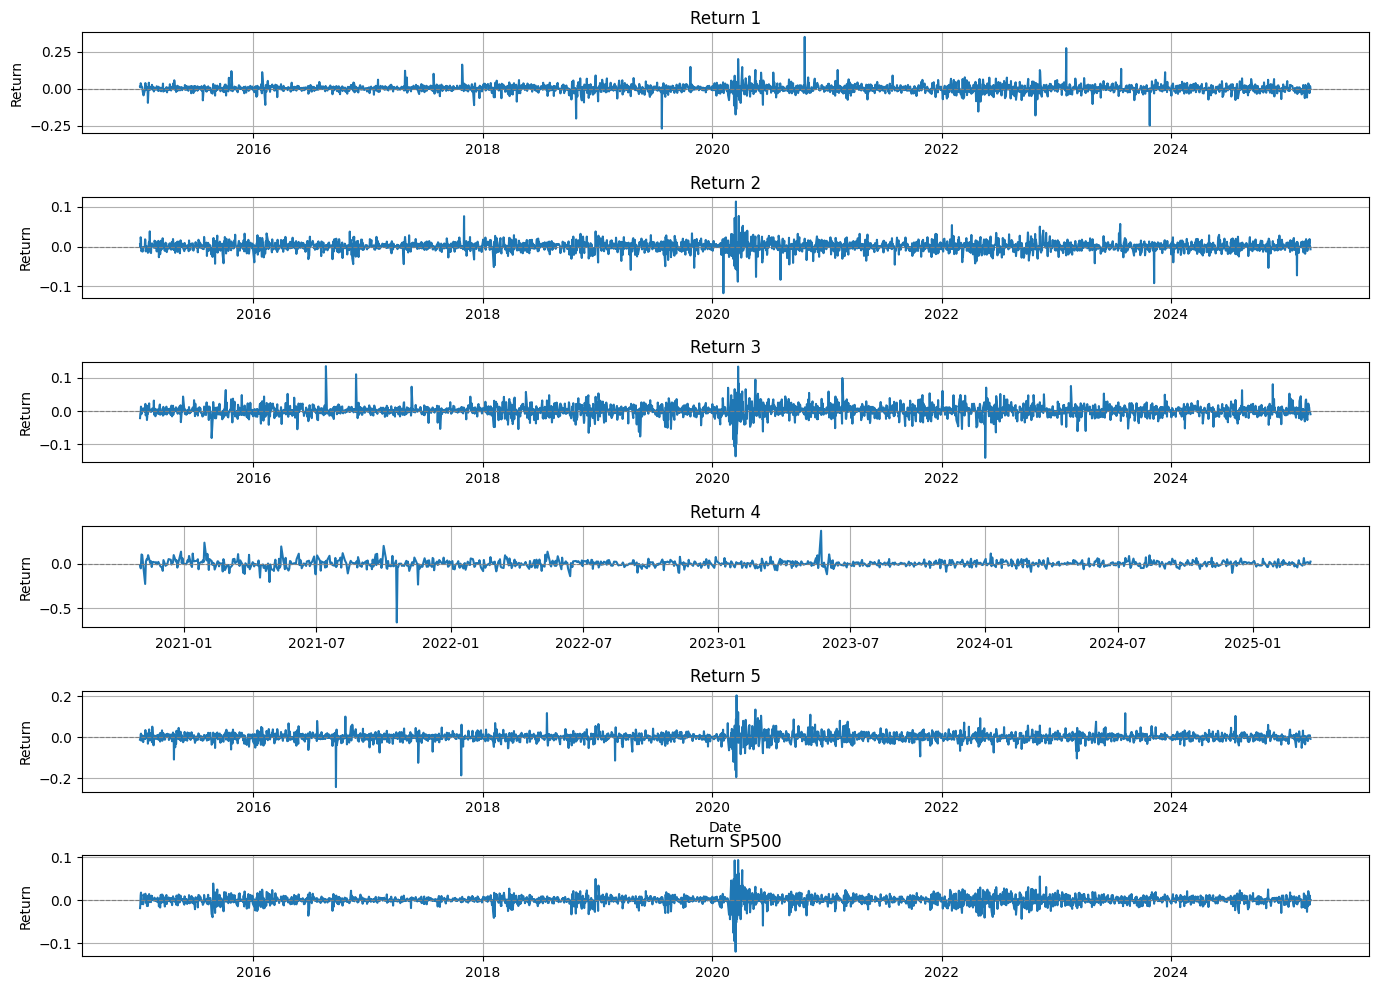

In [10]:
plt.figure(figsize=(14, 10))

return_cols_count = sum([1 if ('return' in col) else 0 for col in merged_df.columns])
# test_i timeseries
for i in range(1, 6):
    plt.subplot(return_cols_count, 1, i)
    plt.plot(merged_df['Date'], merged_df[f'return_{i}'], label=f'Return {i}', color='tab:blue')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.ylabel('Return')
    plt.title(f'Return {i}')
    plt.grid(True)
    if i == 5:
        plt.xlabel('Date')

# indices timeseries
for i in range(len(indices_names)):
    plt.subplot(return_cols_count, 1, i+return_cols_count)
    plt.tight_layout()
    plt.plot(merged_df['Date'], merged_df[f'return_{indices_names[i]}'], label=f'Return {indices_names[i]}', color='tab:blue')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.ylabel('Return')
    plt.title(f'Return {indices_names[i]}')
    plt.grid(True)
plt.show()

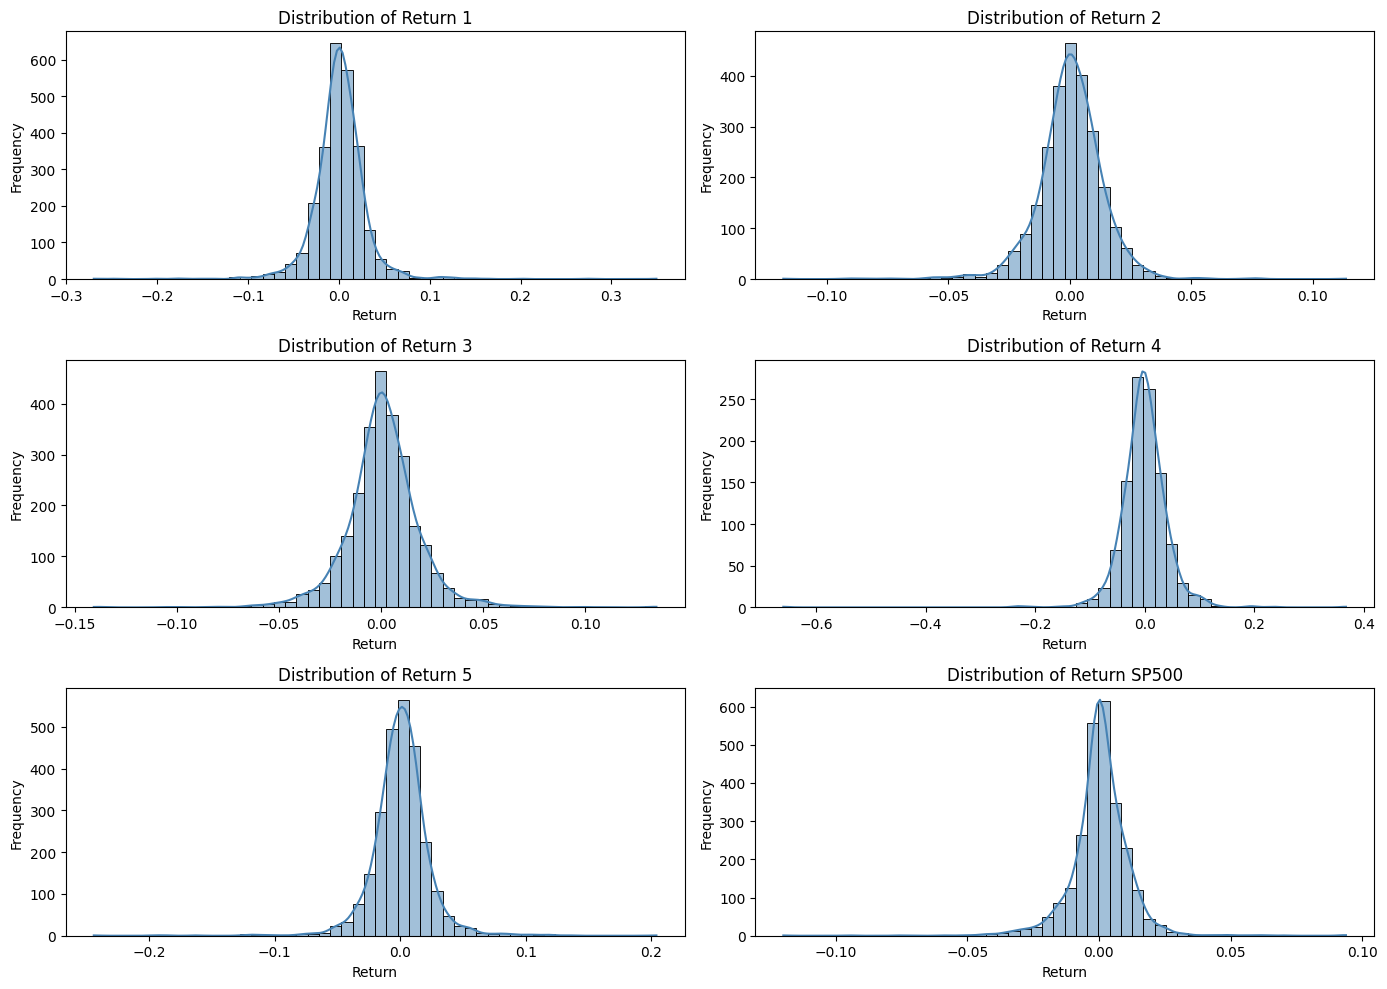

In [11]:
plt.figure(figsize=(14, 10))

for i in range(1, 6):
    plt.subplot(return_cols_count // 2, 2, i)
    sns.histplot(merged_df[f'return_{i}'].dropna(), kde=True, bins=50, color='steelblue')
    plt.title(f'Distribution of Return {i}')
    plt.xlabel('Return')
    plt.ylabel('Frequency')


for i in range(len(indices_names)):
    plt.subplot(return_cols_count // 2, 2, i+6)
    sns.histplot(merged_df[f'return_{indices_names[i]}'].dropna(), kde=True, bins=50, color='steelblue')
    plt.title(f'Distribution of Return {indices_names[i]}')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

Временные ряды и распределения каждого 'return_i' выглядят довольно похоже, особенно гистограммы, которые показывают нормальное распределение, правда с заметными выбросами (которые позже будут обработаны). Из-за этого факта далее для других колонок я буду строить графики только для третьей тестовой акции (для простоты). 

In [12]:
test_idx_to_plot = 3

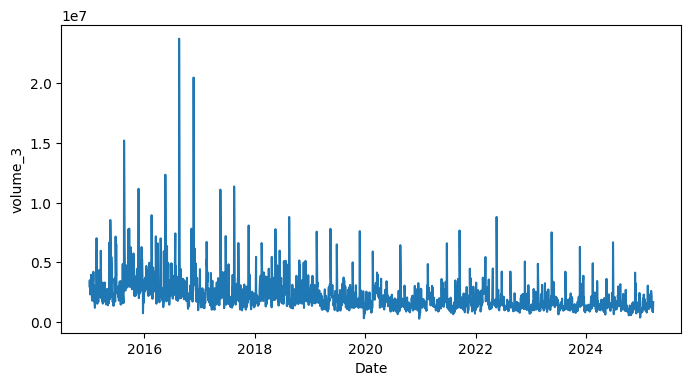

In [13]:
# volume over time
# another visible outliers
plt.figure(figsize=(8, 4))
sns.lineplot(x=merged_df['Date'], y=merged_df[f'volume_{test_idx_to_plot}']);

In [14]:
# пики 'volume' кореллируют с пиковыми значениями 'return'
print(merged_df[merged_df[f'volume_{test_idx_to_plot}'] == merged_df[f'volume_{test_idx_to_plot}'].max()]['Date'])
print(merged_df[merged_df[f'return_{test_idx_to_plot}'] == merged_df[f'return_{test_idx_to_plot}'].max()]['Date'])

410   2016-08-19
Name: Date, dtype: datetime64[ns]
410   2016-08-19
Name: Date, dtype: datetime64[ns]


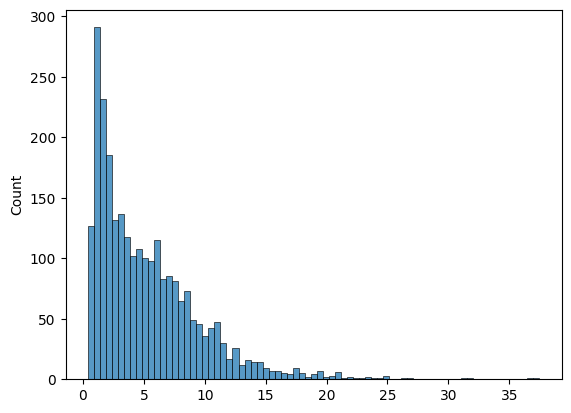

In [15]:
# (high - low) delta histogramm
# самые частые разницы болье нуля, но близки к нему
sns.histplot(data=merged_df[f'high_{test_idx_to_plot}'] - merged_df[f'low_{test_idx_to_plot}'], stat='count', bins=75);

                 0  return_3
0         1.000000 -0.014162
return_3 -0.014162  1.000000


<Axes: ylabel='return_3'>

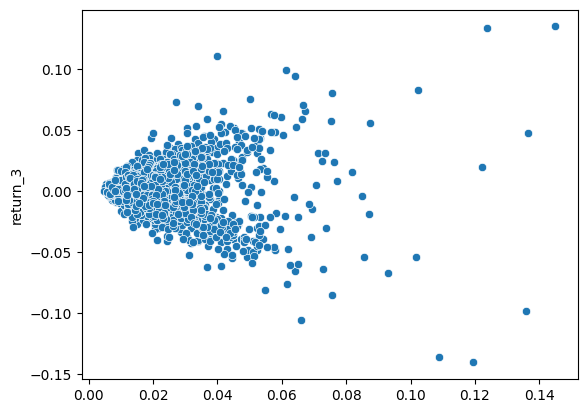

In [16]:
# (high - low) delta ratio and corr with target
high_low_delta_ratio = (merged_df[f'high_{test_idx_to_plot}'] - merged_df[f'low_{test_idx_to_plot}']) / merged_df[f'low_{test_idx_to_plot}']
target = merged_df[f'return_{test_idx_to_plot}']
print(pd.concat((high_low_delta_ratio, target), axis=1).corr())
sns.scatterplot(x=high_low_delta_ratio, y=target)
# higher volatility -> lower price tomorrow (negative corr)

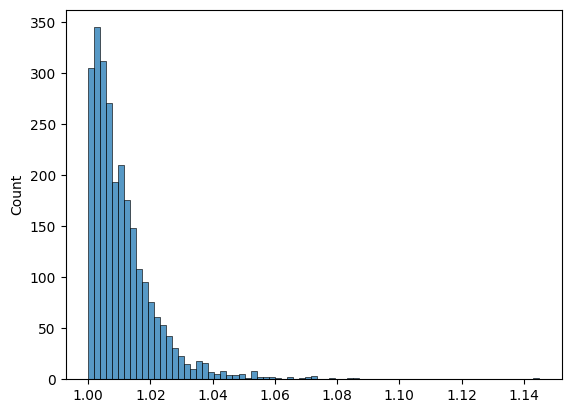

In [17]:
# high to open ratio
sns.histplot(data=merged_df[f'high_{test_idx_to_plot}'] / merged_df[f'open_{test_idx_to_plot}'], stat='count', bins=75);

                 0  return_3
0         1.000000  0.573212
return_3  0.573212  1.000000


<Axes: ylabel='return_3'>

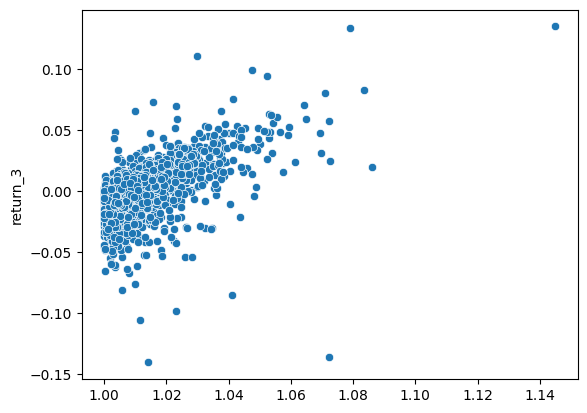

In [18]:
# high to open ratio and corr with target
high_open_ratio = (merged_df[f'high_{test_idx_to_plot}'] / merged_df[f'open_{test_idx_to_plot}'])
target = merged_df[f'return_{test_idx_to_plot}']
print(pd.concat((high_open_ratio, target), axis=1).corr())
sns.scatterplot(x=high_open_ratio, y=target)
# I can interpret that if the High rises too much relative to Open in one day -> 
# -> relative returns also increases (positive corr)

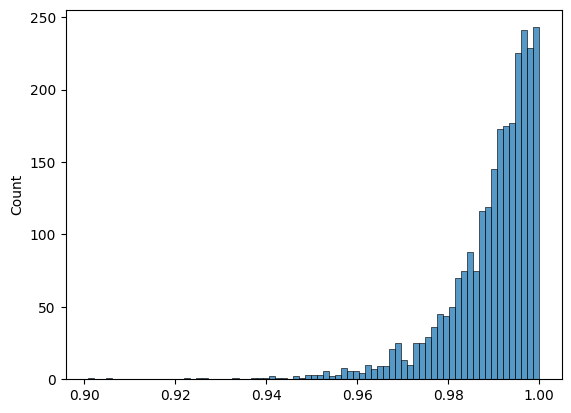

In [19]:
# low to open ratio
sns.histplot(data=merged_df[f'low_{test_idx_to_plot}'] / merged_df[f'open_{test_idx_to_plot}'], stat='count', bins=75);

                 0  return_3
0         1.000000  0.591308
return_3  0.591308  1.000000


<Axes: ylabel='return_3'>

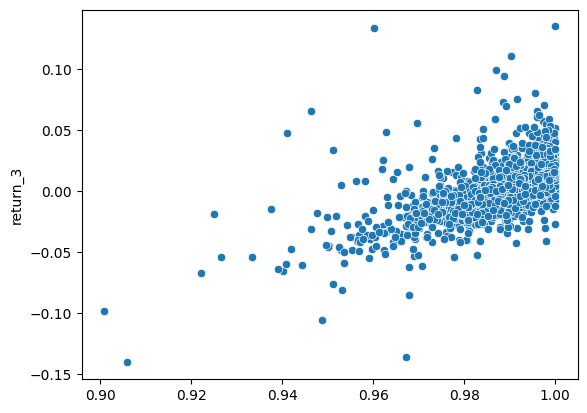

In [20]:
# low to open ratio and corr with target
low_open_ratio = (merged_df[f'low_{test_idx_to_plot}'] / merged_df[f'open_{test_idx_to_plot}'])
target = merged_df[f'return_{test_idx_to_plot}']
print(pd.concat((low_open_ratio, target), axis=1).corr())
sns.scatterplot(x=low_open_ratio, y=target)

<Axes: xlabel='Date', ylabel='close_3'>

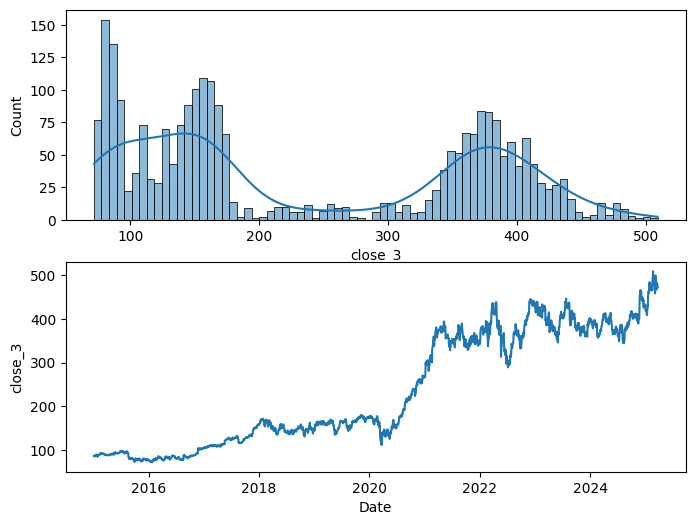

In [21]:
# close distribution and timeseries
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
sns.histplot(merged_df[f'close_{test_idx_to_plot}'] , kde=True, bins=75)
plt.subplot(2, 1, 2)
sns.lineplot(x=merged_df['Date'], y=merged_df[f'close_{test_idx_to_plot}'])

По графику return_3 видно, что в начале 2020 года было большое кол-во пиков, как вниз, так и вверх. Судя по всему это объясняется тем, что в 2020 случилось резкое повышение цены на акцию (close_3), что увеличило интерес инвесторов и количество сделок, из-за чего повысилась волатильность рынка. Отсюда и пики в return_3. Похожую ситуацию можно наблюдать и с остальными тестовыми акциями.

['low_3', 'high_3', 'open_3', 'return_3', 'close_3', 'volume_3']


<Axes: >

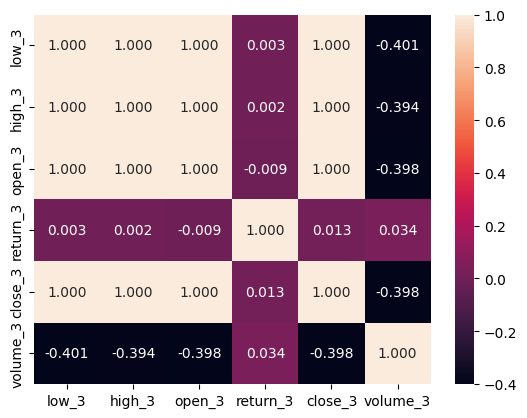

In [22]:
# корреляция основых фичей
features = [col for col in merged_df if str(test_idx_to_plot) in col]
print(features)
sns.heatmap(merged_df[features].corr(), annot=True, fmt='.3f')

Как видно, наш таргет return_i ни с чем не коррелирует, что хорошо. Но сами фичи имеют очень высокую корреляцию между собой, что не очень хорошо, т.к. они по сути несут одну и ту же информацию (не считая volume). Чтобы улучшить ситуацию, нужно сделать feature engineering.

# Feature engineering

In [23]:
def find_outliers_three_sig(df, exclude=None):
    result = pd.DataFrame(index=df.index)
    if not exclude:
        cols = [col for col in df.columns if col]
    else:
        cols = [col for col in df.columns if col not in exclude]

    for col in cols:
        mean = df[col].mean()
        std = df[col].std()

        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        result[f'{col}_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    return result


# capping outliers with border values,
# we don't want to use mean or median because we'd lost usefull info about big deals 
#     or historic spikes
def clip_outliers(df, cols=None):
    assert cols is not None
    df_clean = df.copy()
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        lower = mean - 3 * std
        upper = mean + 3 * std

        df_clean[col] = df[col].clip(lower=lower, upper=upper)
    return df_clean

In [24]:
# перед feature engineering обработаем выбросы, в т.ч. в таргете
outlier_count_df = find_outliers_three_sig(merged_df, exclude=['Date'])
print(outlier_count_df.sum())

low_1_outlier            0
high_1_outlier           0
open_1_outlier           0
return_1_outlier        38
close_1_outlier          0
volume_1_outlier        33
low_2_outlier            0
high_2_outlier           0
open_2_outlier           0
return_2_outlier        34
close_2_outlier          0
volume_2_outlier        40
low_3_outlier            0
high_3_outlier           0
open_3_outlier           0
return_3_outlier        34
close_3_outlier          0
volume_3_outlier        48
low_4_outlier           33
high_4_outlier          35
open_4_outlier          34
return_4_outlier        10
close_4_outlier         34
volume_4_outlier         3
low_5_outlier            0
high_5_outlier           0
open_5_outlier           0
return_5_outlier        39
close_5_outlier          0
volume_5_outlier        26
return_SP500_outlier    36
dtype: int64


In [25]:
postfix = len('_outlier')
columns_with_outliers = [k[:-postfix] for k, v in dict(outlier_count_df.sum()).items() if v > 0]
merge_df_clean = clip_outliers(merged_df, columns_with_outliers)

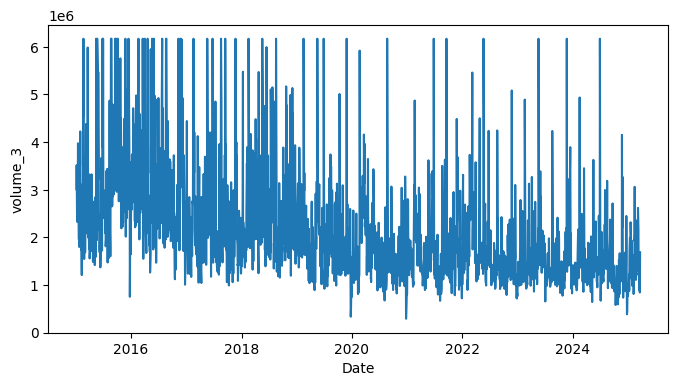

In [26]:
# outliers gone
plt.figure(figsize=(8, 4))
sns.lineplot(x=merge_df_clean['Date'], y=merge_df_clean[f'volume_{test_idx_to_plot}']);

В качестве новых фичей посчитаем ratios, delta из EDA и спецефические для акций признаки: rolling (moving) mean & std, beta, day, month, year.

In [27]:
def apply_datetime_features(df):
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    
    return df


# applying rolling (moving) to 'close' is standard
def apply_rolling_mean_std(df, split_idx, chosen_column='close', days_range=[10, 20,]):
    col_widx = f'{chosen_column}_{split_idx}'
    for day_range in days_range:
        df[f'{col_widx}_ma{day_range}'] = df[col_widx].rolling(window=day_range).mean()
        df[f'{col_widx}_mstd{day_range}'] = df[col_widx].rolling(window=day_range).std()
    return df


# adding beta coefficient between test_i 'returns' and indices 'returns' as feature
# for capturing relation between general movement of market and test_i 
# (indices contains a lot of diffretnt stocks)
def apply_beta_from_indices(df, split_idx, indices_names=['SP500'], windows=[10], chosen_column='return'):
    col_widx = f'{chosen_column}_{split_idx}'
    
    for indice_name in indices_names:
        return_indice_col = f'return_{indice_name}'
        for window in windows:
            rolling_cov = df[[f'{col_widx}', return_indice_col]].rolling(window=window).cov()

            cov = rolling_cov.loc[
                    rolling_cov.index.get_level_values(1) == return_indice_col,
                    f'{col_widx}'
            ].reset_index(drop=True)
            var =  df[return_indice_col].rolling(window=window).var()

            df[f'beta_{col_widx}_{indice_name}'] = cov / var

    return df


# EDA features
def apply_high_low_delta_ratio(df, split_idx):
    high_col, low_col = df[f'high_{split_idx}'], df[f'low_{split_idx}']
    df[f'high_low_delta_{split_idx}'] = (high_col - low_col) / low_col
    return df


def apply_high_open_ratio(df, split_idx):
    high_col, open_col = df[f'high_{split_idx}'], df[f'open_{split_idx}']
    df[f'high_open_ratio_{split_idx}'] = high_col / open_col
    return df


def apply_low_open_ratio(df, split_idx):
    low_col, open_col = df[f'low_{split_idx}'], df[f'open_{split_idx}']
    df[f'low_open_ratio_{split_idx}'] = low_col / open_col
    return df


# dropping some features if they have very big correlation with target
def remove_high_correlated_with_target(df, target_col, exclude_cols=None, threshold=0.7):
    if exclude_cols is None:
        exclude_cols = []
    exclude_cols = exclude_cols + [target_col]

    corr_with_target = df.corr()[target_col].abs()
    high_corr_cols = [
        col for col in corr_with_target.index
        if col not in exclude_cols and corr_with_target[col] >= threshold
    ]

    df_filtered = df.drop(columns=high_corr_cols)   
    return df_filtered, high_corr_cols  

# Data pipeline

In [28]:
# for particular test_i split
# read data return_i -> clip outliers -> dropna
def full_ts_data_pipeline(test_path, split_idx):
    test_i_series = read_test_i_dataframe(test_path, split_idx)
    test_i_series = test_i_series[['Date', f'return_{split_idx}']]
    test_i_series['Date'] = pd.to_datetime(test_i_series['Date'])
    test_i_series = test_i_series.sort_values('Date').reset_index(drop=True)

    outlier_count_df = find_outliers_three_sig(test_i_series, exclude=['Date'])
    postfix = len('_outlier')
    columns_with_outliers = [k[:-postfix] for k, v in dict(outlier_count_df.sum()).items() if v > 0]
    test_i_series = clip_outliers(test_i_series, columns_with_outliers)

    test_i_series = test_i_series.dropna()
    return test_i_series


# for particular test_i split
# read data -> add indices data -> clip outliers -> add features -> dropna (from rolling features) ->
#     remove target-correlated features -> X y timeseries parts -> train_test_split -> StandardScaler
def full_nn_data_pipeline(test_path, indices_path, indices_names, split_idx, corr_thresh=0.7):
    # read data and sort by date
    test_i_df = read_test_i_dataframe(test_path, split_idx)
    test_i_df = add_indices_dfs(test_i_df, indices_path, indices_names)

    test_i_df['Date'] = pd.to_datetime(test_i_df['Date'])
    test_i_df = test_i_df.sort_values('Date').reset_index(drop=True)

    # outliers
    outlier_count_df = find_outliers_three_sig(test_i_df, exclude=['Date'])
    postfix = len('_outlier')
    columns_with_outliers = [k[:-postfix] for k, v in dict(outlier_count_df.sum()).items() if v > 0]
    test_i_df = clip_outliers(test_i_df, columns_with_outliers)

    # features
    test_i_df = apply_datetime_features(test_i_df)
    test_i_df = apply_rolling_mean_std(test_i_df, split_idx)
    test_i_df = apply_beta_from_indices(test_i_df, split_idx)
    
    test_i_df = apply_high_low_delta_ratio(test_i_df, split_idx)
    test_i_df = apply_high_open_ratio(test_i_df, split_idx)
    test_i_df = apply_low_open_ratio(test_i_df, split_idx)
    
    # correlation fix
    test_i_df, _ = remove_high_correlated_with_target(test_i_df, f'return_{split_idx}', threshold=corr_thresh)

    # dropping NaN's because of rolling features
    test_i_df = test_i_df.dropna()
        
    return test_i_df

In [29]:
test_3_series = full_ts_data_pipeline(test_path, 3)
test_3_series.head()

,Date,return_3
0,2015-01-05,-0.021394
1,2015-01-06,-0.008329
2,2015-01-07,-0.004316
3,2015-01-08,0.013238
4,2015-01-09,-0.009712


In [30]:
test_3_df = full_nn_data_pipeline(test_path, indices_path, indices_names, 3)
print(test_3_df.shape, test_3_df.columns)
#test_3_df.head()

(2550, 20) Index(['Date', 'open_3', 'high_3', 'low_3', 'close_3', 'return_3', 'volume_3',
       'return_SP500', 'Day_of_Week', 'Day', 'Month', 'Year', 'close_3_ma10',
       'close_3_mstd10', 'close_3_ma20', 'close_3_mstd20',
       'beta_return_3_SP500', 'high_low_delta_3', 'high_open_ratio_3',
       'low_open_ratio_3'],
      dtype='object')


<Axes: >

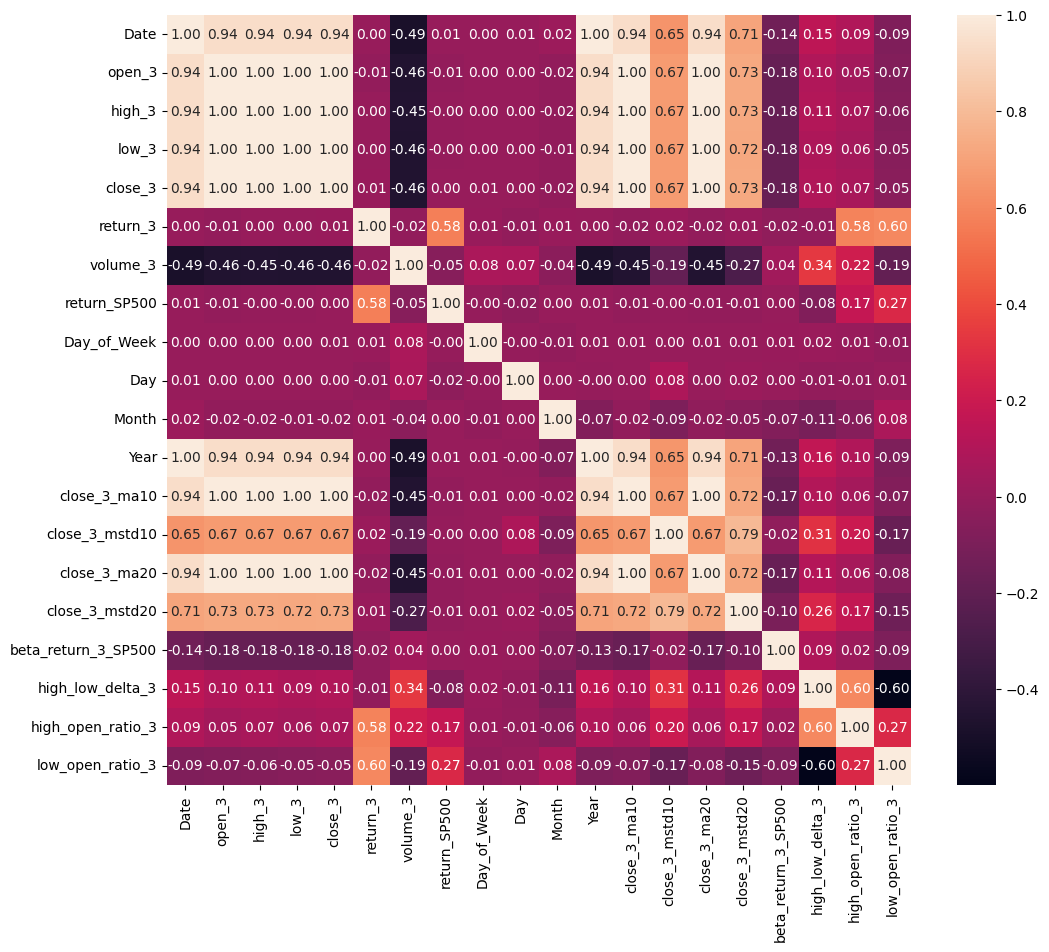

In [31]:
# visualise final features correlations for one of the test_i stock
plt.figure(figsize=(12, 10))
sns.heatmap(test_3_df.corr(), annot=True, fmt='.2f')

# LightAutoML

К моменту фита моделей понял, что я так просто не смогу все свои фичи использовать. С нейронной сетью понятно как скормить все фичи, но с TabularAutoML это просто так работать не будет, т.к. при авторегрессионном предикте надо каким то образом будет обновлять весь набор фичей, чего сделать нельзя. А нативного multi-output в TabularAutoML нет.

Единственное решение, которое я нашел - использовать AutoTS пресет из lightautoml.addons, основную фичу return_i + transformers_params для lag-фичей. Trend_params можно не задавать, т.к. наш таргет 'return' не имеет видимых трендов.

In [32]:
# пять тестовых акций -> пять разных autoTS моделей -> предикт 'returns' на 10 дней (авторегрессионно)

class AutoTsPredictor:
    def __init__(self, test_path, preproc_func, history, n_threads=N_THREADS, n_folds=N_FOLDS,
                 timeout=TIMEOUT, horizon=HORIZON, random_state=RANDOM_STATE):
        self.test_path = test_path
        self.n_threads = n_threads
        self.n_folds = n_folds
        self.timeout = timeout
        self.horizon = horizon
        self.random_state = random_state

        self.preproc_func = preproc_func
        self.history = history
        self.series = {}
        self.models = {}

    def fit_model(self, split_idx):
        assert self.horizon == self.history
        df_i = self.preproc_func(self.test_path, split_idx)
        target_col = f'return_{split_idx}'
        train = df_i
        
        task = Task("multi:reg", greater_is_better=False, metric="mae", loss="mae")

        univariate_roles = {
            "target": target_col,
            DatetimeRole(seasonality=('d', 'm', 'wd'), base_date=True): 'Date',
        }
        
        seq_params = {
            "seq0": {
                "case": "next_values",                  
                "params": {"n_target": self.horizon, "history": self.history,                              
                    "step": 1, "from_last": True, "test_last": True,}
        }}

        transformers_params = {
            "lag_features": [1, 3, 5],
            "lag_time_features": [1, 5, 10],
            "diff_features": [1, 5, 10],
        }

        automl = AutoTS(task,
            reader_params = {
                "seq_params": seq_params, 'random_state': self.random_state
            },
            time_series_trend_params={
                "trend": False,
            },
            time_series_pipeline_params=transformers_params
        )

        univariate_train_pred, _ = automl.fit_predict(train, univariate_roles, verbose=1)

        self.series[split_idx] = train
        self.models[split_idx] = automl

    def predict(self, split_idx, pred_horizon=10):
        assert split_idx in self.models.keys() and split_idx in self.series.keys()

        target_col = f'return_{split_idx}'
        predictions = []

        current_data = self.series[split_idx].copy()
        for day in range(0, pred_horizon, self.horizon):
            forecast, _ = self.models[split_idx].predict(current_data)
            last_forecast = forecast[-1]  # (2,)    
            predictions.append(last_forecast[0])
            predictions.append(last_forecast[1])

            last_date = current_data['Date'].iloc[-1]
            new_rows = pd.DataFrame({
                'Date': [last_date + pd.Timedelta(days=1), last_date + pd.Timedelta(days=2)],
                target_col: [last_forecast[0], last_forecast[1]],
            })

            current_data = pd.concat([current_data, new_rows], ignore_index=True)
        
        return predictions
        

Оказалось, что модель не запускается, если history != horizon. Хотя по идее хотелось бы иметь возможность ставить history больше чем horizon, например на основе 100 предыдущих значений форекастить 10 следующих. Помимо того, модель отказывается обучаться на моих данных, если горизонт предсказания больше двух. Пришлось прикрутить авторегрессионный костыль. Возможно я где-то ошибся, но делал всё по туториалу: https://colab.research.google.com/github/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_11_time_series.ipynb#scrollTo=qWixL5rBLKjf

In [33]:
automl_ts_models = AutoTsPredictor(test_path, full_ts_data_pipeline, history=2, horizon=2)

In [34]:
for i in range(1, 6):
    automl_ts_models.fit_model(i)

preds = {}
for i in range(1, 6):
    preds[i] = automl_ts_models.predict(i)

multi:reg isn`t supported in lgb
multi:reg isn`t supported in xgb
[22:23:43] Stdout logging level is INFO.
[22:23:43] Task: multi:reg

[22:23:43] Start automl preset with listed constraints:
[22:23:43] - time: 3600.00 seconds
[22:23:43] - CPU: 4 cores
[22:23:43] - memory: 16 GB

[22:23:43] Layer 1 train process start. Time left 3599.89 secs
[22:23:43] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[22:23:45] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -0.019487014065828125
[22:23:45] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[22:23:45] Time left 3597.78 secs

[22:23:45] Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...
[22:23:45] Fitting Lvl_0_Pipe_1_Mod_0_LinearL2 finished. score = -0.019396834187129355
[22:23:45] Lvl_0_Pipe_1_Mod_0_LinearL2 fitting and predicting completed
[22:23:45] Time left 3597.53 secs

[22:23:45] Start fitting Lvl_0_Pipe_2_Mod_0_CatBoost ...
[22:23:46] Fitting Lvl_0_Pipe_2_Mod_0_CatBoost finished. score = -0.019394260033532788
[22:23:4

In [35]:
sample_submission = pd.read_csv('/kaggle/input/stock-price-prediction-challenge/sample_submission.csv')
dates_from_sample = sample_submission['Date']
submission_df = pd.DataFrame(dates_from_sample, columns=['Date'])

for k, v in preds.items():
    return_col = f'return_{k}'
    submission_df[return_col] = v

submission_df.to_csv('submission_autots.csv', index=False)
print(submission_df.head())

         Date  return_1  return_2  return_3  return_4  return_5
0  2025-03-25  0.000139 -0.000172  0.000437 -0.004165  0.000685
1  2025-03-26  0.000914  0.000599  0.001135 -0.000665  0.000673
2  2025-03-27 -0.000206  0.000118  0.000506 -0.004008  0.000685
3  2025-03-28  0.000659  0.000846  0.001221 -0.000555  0.000673
4  2025-03-31 -0.000097  0.000010  0.000433 -0.003068  0.000644


# LSTM

В LSTM подам все собранные фичи, буду учить на промежутках N дней - 10 дней. Для каждой акции так же своя модель.

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=HORIZON, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)
        return output


def fit_predict_lstm(test_path, indices_path, indices_names, seq_length=100, horizon=HORIZON):
    predictions = {}
    results = {}

    for stock_idx in range(1, 6):

        # higher corr_thresh
        df = full_nn_data_pipeline(test_path, indices_path, indices_names, stock_idx, corr_thresh=0.5)
        target_col = f'return_{stock_idx}'

        feature_cols = [col for col in df.columns if col not in ['Date', target_col]]
        all_cols = feature_cols + [target_col]
        
        # simple scaling
        scaler_features = StandardScaler()
        scaler_target = StandardScaler()
        df_scaled = df[all_cols].copy()
        df_scaled[feature_cols] = scaler_features.fit_transform(df[feature_cols])
        df_scaled[target_col] = scaler_target.fit_transform(df[[target_col]])
        
        # X, y split
        X, y = [], []
        for i in range(seq_length, len(df_scaled) - horizon):
            X_seq = df_scaled[all_cols].iloc[i-seq_length:i].values
            y_seq = df_scaled[target_col].iloc[i:i+horizon].values
            X.append(X_seq)
            y.append(y_seq)

        X, y = np.array(X), np.array(y)
        n_features = X.shape[2]

        train_size = int(len(X) * (1-TEST_SIZE))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        X_train_tensor = torch.Tensor(X_train)
        y_train_tensor = torch.Tensor(y_train)
        X_test_tensor = torch.Tensor(X_test)
        y_test_tensor = torch.Tensor(y_test)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        valid_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

        # model
        model = LSTMModel(
            input_size=n_features,
            hidden_size=32,
            output_size=horizon,
            num_layers=1,
            dropout=0.3
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        epochs = 5
        train_losses, val_losses = [], []

        # train + valid
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                preds = model(batch_X)
                loss = criterion(preds, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in valid_loader:
                    val_preds = model(batch_X)
                    loss = criterion(val_preds, batch_y)
                    val_loss += loss.item()
            
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(valid_loader))
            
            if (epoch + 1) % 1 == 0:
                print(f'epoch {epoch}, train_loss: {train_losses[-1]:.6f}, '
                      f'val_loss: {val_losses[-1]:.6f}')

        # forecast
        model.eval()
        with torch.no_grad():
            last_data = df_scaled[all_cols].iloc[-seq_length:].values
            last_data = torch.Tensor(last_data).unsqueeze(0)

            preds_return = model(last_data).numpy()
            preds_return = scaler_target.inverse_transform(preds_return)

        predictions[f'return_{stock_idx}'] = preds_return.flatten()

        results[stock_idx] = {
            'model': model,
            'scaler_target': scaler_target,
            'scaler_features': scaler_features,
            'predictions': preds_return.flatten(),
            'train_loss': train_losses,
            'val_loss': val_losses
        }

    return predictions, results

In [37]:
submission_preds, lstm_fit_predict_results = fit_predict_lstm(test_path, indices_path, indices_names, seq_length=100, horizon=HORIZON)

(1952, 100, 16) (488, 100, 16) (1952, 10) (488, 10)
epoch 0, train_loss: 1.064909, val_loss: 0.954126
epoch 1, train_loss: 1.058928, val_loss: 0.954454
epoch 2, train_loss: 1.055357, val_loss: 0.957826
epoch 3, train_loss: 1.053301, val_loss: 0.961652
epoch 4, train_loss: 1.052827, val_loss: 0.965029
(1952, 100, 17) (488, 100, 17) (1952, 10) (488, 10)
epoch 0, train_loss: 1.091343, val_loss: 0.780682
epoch 1, train_loss: 1.081005, val_loss: 0.778644
epoch 2, train_loss: 1.076600, val_loss: 0.777428
epoch 3, train_loss: 1.074215, val_loss: 0.778471
epoch 4, train_loss: 1.071062, val_loss: 0.778563
(1952, 100, 16) (488, 100, 16) (1952, 10) (488, 10)
epoch 0, train_loss: 1.091205, val_loss: 0.853853
epoch 1, train_loss: 1.083498, val_loss: 0.852350
epoch 2, train_loss: 1.081133, val_loss: 0.853071
epoch 3, train_loss: 1.077663, val_loss: 0.853647
epoch 4, train_loss: 1.076042, val_loss: 0.854583
(777, 100, 17) (195, 100, 17) (777, 10) (195, 10)
epoch 0, train_loss: 0.994752, val_loss: 0.5

Эмпирически выявил, что модели быстро переобучаются. Чтобы это исправить у lstm уменьшил hidden_size, выставил num_layers=1, увеличил дропаут, поставил большой seq_length, уменьшил corr_thresh для фичей.

In [38]:
sample_submission = pd.read_csv('/kaggle/input/stock-price-prediction-challenge/sample_submission.csv')
dates_from_sample = sample_submission['Date']
submission_df = pd.DataFrame(dates_from_sample, columns=['Date'])

for k, v in submission_preds.items():
    return_col = k
    submission_df[return_col] = v.tolist()

submission_df.to_csv('submission_lstm.csv', index=False)
print(submission_df.head())

         Date  return_1  return_2  return_3  return_4  return_5
0  2025-03-25  0.006939  0.002495 -0.003045 -0.004072 -0.001660
1  2025-03-26  0.004691  0.000264 -0.001635  0.000066 -0.002445
2  2025-03-27  0.005677  0.002646 -0.002797 -0.001462 -0.002574
3  2025-03-28  0.004514  0.002215 -0.002989 -0.001152  0.000103
4  2025-03-31  0.007079  0.001537 -0.001751 -0.001364 -0.004248


# Simple LSTM

Раз уж доп. фичи переобучают модель, попробуем зафитить LSTM буквально на одном признаке return_i.

In [68]:
def fit_predict_lstm_simple(test_path, seq_length=100, horizon=HORIZON):
    predictions = {}
    results = {}

    for stock_idx in range(1, 6):

        # baseline data pipeline
        df = full_ts_data_pipeline(test_path, stock_idx)
        target_col = f'return_{stock_idx}'

        # simple scaling
        scaler = StandardScaler()
        df_scaled = df[[target_col]].copy()
        df_scaled[target_col] = scaler.fit_transform(df[[target_col]])
        
        # X, y split
        X, y = [], []
        for i in range(seq_length, len(df_scaled) - horizon):
            X_seq = df_scaled[target_col].iloc[i-seq_length:i].values.reshape(-1, 1)
            y_seq = df_scaled[target_col].iloc[i:i+horizon].values
            X.append(X_seq)
            y.append(y_seq)

        X, y = np.array(X), np.array(y)
        n_features = 1

        train_size = int(len(X) * (1-TEST_SIZE))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        X_train_tensor = torch.Tensor(X_train)
        y_train_tensor = torch.Tensor(y_train)
        X_test_tensor = torch.Tensor(X_test)
        y_test_tensor = torch.Tensor(y_test)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        valid_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

        # model
        model = LSTMModel(
            input_size=n_features,
            hidden_size=32,
            output_size=horizon,
            num_layers=1,
            dropout=0.3
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        epochs = 5
        train_losses, val_losses = [], []

        # train + valid
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                preds = model(batch_X)
                loss = criterion(preds, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in valid_loader:
                    val_preds = model(batch_X)
                    loss = criterion(val_preds, batch_y)
                    val_loss += loss.item()
            
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(valid_loader))
            
            if (epoch + 1) % 1 == 0:
                print(f'epoch {epoch}, train_loss: {train_losses[-1]:.6f}, '
                      f'val_loss: {val_losses[-1]:.6f}')

        # forecast
        model.eval()
        with torch.no_grad():
            last_data = df_scaled[target_col].iloc[-seq_length:].values.reshape(1, seq_length, 1)
            last_data = torch.Tensor(last_data)

            preds_return = model(last_data).numpy()
            preds_return = scaler.inverse_transform(preds_return)

        predictions[target_col] = preds_return.flatten()

        results[stock_idx] = {
            'model': model,
            'scaler': scaler,
            'predictions': preds_return.flatten(),
            'train_loss': train_losses,
            'val_loss': val_losses
        }

    return predictions, results

In [69]:
submission_preds, lstm_simple_fit_predict_results = fit_predict_lstm_simple(test_path, seq_length=100, horizon=HORIZON)

(1967, 100, 1) (492, 100, 1) (1967, 10) (492, 10)
epoch 0, train_loss: 1.052490, val_loss: 0.949114
epoch 1, train_loss: 1.045517, val_loss: 0.947382
epoch 2, train_loss: 1.044502, val_loss: 0.947541
epoch 3, train_loss: 1.049111, val_loss: 0.947322
epoch 4, train_loss: 1.043362, val_loss: 0.947044
(1967, 100, 1) (492, 100, 1) (1967, 10) (492, 10)
epoch 0, train_loss: 1.085459, val_loss: 0.776646
epoch 1, train_loss: 1.075226, val_loss: 0.774974
epoch 2, train_loss: 1.073704, val_loss: 0.774694
epoch 3, train_loss: 1.071394, val_loss: 0.774653
epoch 4, train_loss: 1.072841, val_loss: 0.774074
(1967, 100, 1) (492, 100, 1) (1967, 10) (492, 10)
epoch 0, train_loss: 1.083112, val_loss: 0.850104
epoch 1, train_loss: 1.078116, val_loss: 0.850027
epoch 2, train_loss: 1.081665, val_loss: 0.849619
epoch 3, train_loss: 1.079622, val_loss: 0.849865
epoch 4, train_loss: 1.076938, val_loss: 0.849860
(792, 100, 1) (199, 100, 1) (792, 10) (199, 10)
epoch 0, train_loss: 0.996233, val_loss: 0.581617
ep

In [70]:
sample_submission = pd.read_csv('/kaggle/input/stock-price-prediction-challenge/sample_submission.csv')
dates_from_sample = sample_submission['Date']
submission_df = pd.DataFrame(dates_from_sample, columns=['Date'])

for k, v in submission_preds.items():
    return_col = k
    submission_df[return_col] = v.tolist()

submission_df.to_csv('submission_lstm_simple.csv', index=False)
print(submission_df.head())

         Date  return_1  return_2  return_3  return_4  return_5
0  2025-03-25  0.001099  0.000336  0.001318 -0.001015  0.000495
1  2025-03-26  0.000951  0.000188  0.001062 -0.001810  0.000524
2  2025-03-27  0.001141  0.000523  0.001432 -0.001121  0.000331
3  2025-03-28  0.001479  0.000547  0.001308 -0.001572  0.000495
4  2025-03-31  0.001238  0.000379  0.001263 -0.001483  0.000207
